<a href="https://colab.research.google.com/github/yixuanzho/Research-project/blob/main/tests%20/pymc/ODE_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import arviz as az
from scipy.integrate import odeint
from pytensor.compile.ops import as_op

In [2]:
# Set up plotting
az.style.use("arviz-darkgrid")
np.random.seed(1234)

In [3]:
# Data from Run 1 (Table 1)
# Initial values
CXt0 = 0.05  # g/L (Biomass concentration)
CSt0 = 40.0  # g/L (Glucose concentration)
CPt0 = 0.0   # g/L (Succinic Acid - starting at zero)
CBPt0 = 0.0  # g/L (By-Products - starting at zero)

# Parameters from Run 1 (Table 2)
Cxm = 5.02   # g/L
KP1 = 0.007  # L/g/h
KP2 = 0.019  # L/g/h
mu = 0.85    # 1/h
YS_P1 = 0.24 # g/g
YS_P2 = 2.27 # g/g
YS_BP = 1.10 # g/g
YS_X = 1.65  # g/g

In [4]:
# define the right hand side of the ODE equations in the Scipy odeint signature
from numba import njit

@njit
def rhs(X, t, params):
    # Unpack state variables
    CX, CS, CP, CBP = X

    # Unpack parameters
    Cxm, KP1, KP2, mu, YS_P1, YS_P2, YS_BP, YS_X = params

    # Calculate reaction rates (Equations 4-6)
    r1 = mu * CX * (1 - CX / Cxm)
    r2 = KP1 * CS * CX
    r3 = KP2 * CS * CX

    # Calculate production and consumption rates (Equations 7-10)
    dCS_dt = -YS_X * r1 - YS_P1 * r2 - YS_P2 * r3
    dCP_dt = r2
    dCX_dt = r1
    dCBP_dt = YS_BP * r2 + r3

    return [dCX_dt, dCS_dt, dCP_dt, dCBP_dt]

In [5]:
# Generate time points
times = np.linspace(0, 35, 100)  # 35 hours of fermentation

In [6]:
# Run the simulation with the parameters from Table 2
params = [Cxm, KP1, KP2, mu, YS_P1, YS_P2, YS_BP, YS_X]
initial_conditions = [CXt0, CSt0, CPt0, CBPt0]
solution = odeint(func=rhs, y0=initial_conditions, t=times, args=(params,))

In [7]:
# Extract the results
CX = solution[:, 0]  # Biomass
CS = solution[:, 1]  # Glucose
CP = solution[:, 2]  # Succinic Acid
CBP = solution[:, 3] # By-Products

In [8]:
# Print key results to check against paper
print(f"Final biomass: {CX[-1]:.2f} g/L")
print(f"Final succinic acid: {CP[-1]:.2f} g/L")
print(f"Final by-products: {CBP[-1]:.2f} g/L")
print(f"Remaining glucose: {CS[-1]:.2f} g/L")

Final biomass: 5.02 g/L
Final succinic acid: 4.96 g/L
Final by-products: 18.93 g/L
Remaining glucose: 0.04 g/L


<ipython-input-9-fabd3cdcc5e9>:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


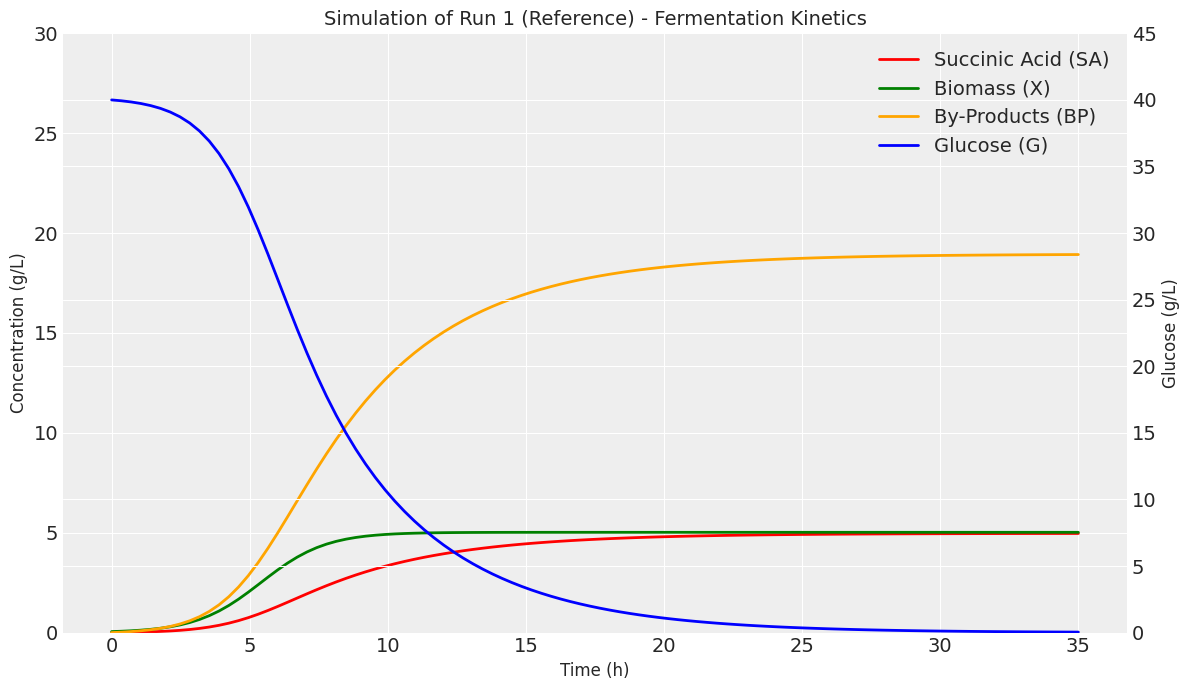

In [9]:
# Plot the results
plt.figure(figsize=(12, 7))

# Primary Y-axis (left)
plt.plot(times, CP, 'r-', linewidth=2, label='Succinic Acid (SA)')
plt.plot(times, CX, 'g-', linewidth=2, label='Biomass (X)')
plt.plot(times, CBP, 'orange', linewidth=2, label='By-Products (BP)')

# Secondary Y-axis (right) for glucose
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(times, CS, 'b-', linewidth=2, label='Glucose (G)')

# Set y-axis limits to match paper figures
ax1.set_ylim(0, 30)  # For SA, BP, and X
ax2.set_ylim(0, 45)  # For glucose

# Add labels and legend
ax1.set_xlabel('Time (h)', fontsize=12)
ax1.set_ylabel('Concentration (g/L)', fontsize=12)
ax2.set_ylabel('Glucose (g/L)', fontsize=12)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('Simulation of Run 1 (Reference) - Fermentation Kinetics', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Create sparse observation data for PyMC model
# Generate observation times
obs_times = np.linspace(0, 35, 20)  # 20 observation points
n_obs = len(obs_times)

In [11]:
# Create function to get values at specific observation times
def get_obs_values(solution, obs_times, times):
    """Interpolate solution at observation times"""
    from scipy.interpolate import interp1d

    # Create interpolation functions for each variable
    interp_funcs = [interp1d(times, solution[:, i]) for i in range(solution.shape[1])]

    # Get values at observation times
    obs_values = np.zeros((len(obs_times), solution.shape[1]))
    for i, func in enumerate(interp_funcs):
        obs_values[:, i] = func(obs_times)

    return obs_values

In [12]:
# Get values at observation times
obs_values = get_obs_values(solution, obs_times, times)
CX_obs = obs_values[:, 0]
CS_obs = obs_values[:, 1]
CP_obs = obs_values[:, 2]
CBP_obs = obs_values[:, 3]

In [13]:
# Add noise to create synthetic observations
np.random.seed(42)  # For reproducibility
noise_level = 0.05  # 5% noise
CX_obs_noisy = CX_obs * (1 + noise_level * np.random.randn(n_obs))
CS_obs_noisy = CS_obs * (1 + noise_level * np.random.randn(n_obs))
CP_obs_noisy = CP_obs * (1 + noise_level * np.random.randn(n_obs))
CBP_obs_noisy = CBP_obs * (1 + noise_level * np.random.randn(n_obs))

# Make sure observations are positive
CX_obs_noisy = np.maximum(CX_obs_noisy, 0.01)
CS_obs_noisy = np.maximum(CS_obs_noisy, 0.01)
CP_obs_noisy = np.maximum(CP_obs_noisy, 0.01)
CBP_obs_noisy = np.maximum(CBP_obs_noisy, 0.01)

<ipython-input-14-0360e4aaab6b>:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


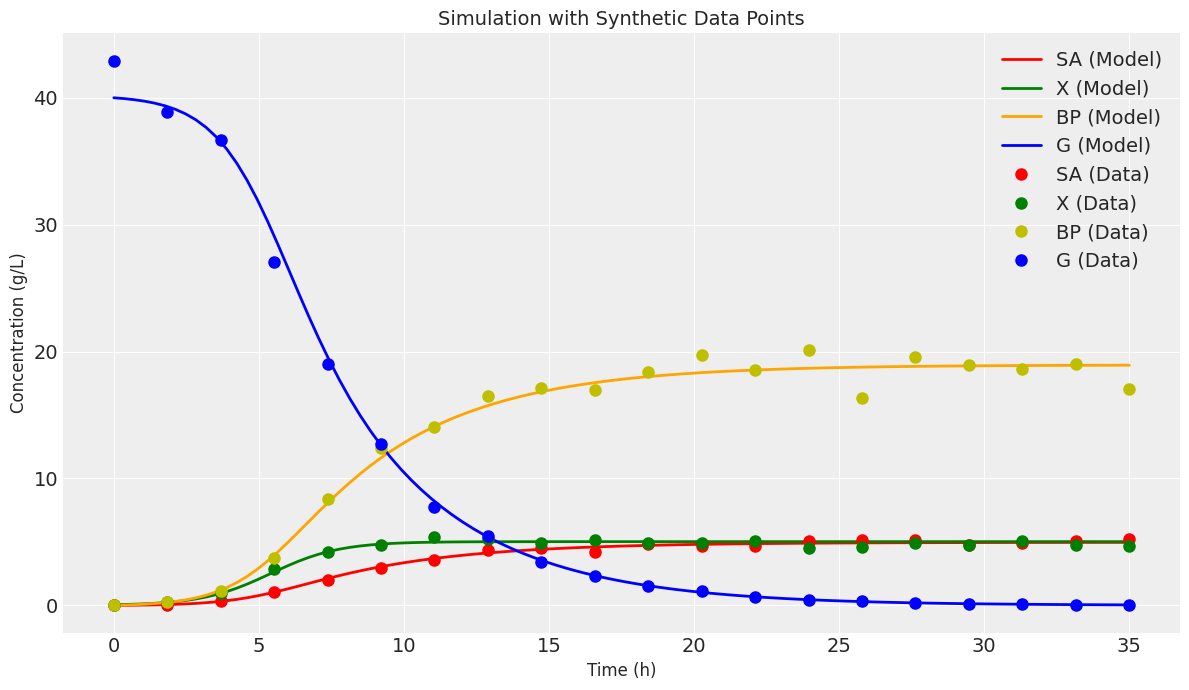

In [14]:
# Plot the model with synthetic data points
plt.figure(figsize=(12, 7))

# Plot the true model
plt.plot(times, CP, 'r-', linewidth=2, label='SA (Model)')
plt.plot(times, CX, 'g-', linewidth=2, label='X (Model)')
plt.plot(times, CBP, 'orange', linewidth=2, label='BP (Model)')
plt.plot(times, CS, 'b-', linewidth=2, label='G (Model)')

# Add the synthetic data points
plt.plot(obs_times, CP_obs_noisy, 'ro', markersize=8, label='SA (Data)')
plt.plot(obs_times, CX_obs_noisy, 'go', markersize=8, label='X (Data)')
plt.plot(obs_times, CBP_obs_noisy, 'yo', markersize=8, label='BP (Data)')
plt.plot(obs_times, CS_obs_noisy, 'bo', markersize=8, label='G (Data)')

plt.xlabel('Time (h)', fontsize=12)
plt.ylabel('Concentration (g/L)', fontsize=12)
plt.title('Simulation with Synthetic Data Points', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Create PyTensor operator for the ODE model for use with PyMC
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_model(theta):
    # Unpack parameters
    Cxm, KP1, KP2, mu, YS_P1, YS_P2, YS_BP, YS_X = theta

    # Run the ODE solver
    params = [Cxm, KP1, KP2, mu, YS_P1, YS_P2, YS_BP, YS_X]
    solution = odeint(func=rhs, y0=initial_conditions, t=obs_times, args=(params,))

    return solution

In [16]:
# Define the PyMC model using the @as_op wrapping of the ODE solver
with pm.Model() as succinic_model:
    # Define priors for parameters (based on values from Table 2)
    Cxm_prior = pm.TruncatedNormal('Cxm', mu=5.02, sigma=0.5, lower=1.0)
    KP1_prior = pm.TruncatedNormal('KP1', mu=0.007, sigma=0.002, lower=0.001)
    KP2_prior = pm.TruncatedNormal('KP2', mu=0.019, sigma=0.005, lower=0.001)
    mu_prior = pm.TruncatedNormal('mu', mu=0.85, sigma=0.1, lower=0.1)
    YS_P1_prior = pm.TruncatedNormal('YS_P1', mu=0.24, sigma=0.05, lower=0.1)
    YS_P2_prior = pm.TruncatedNormal('YS_P2', mu=2.27, sigma=0.3, lower=0.1)
    YS_BP_prior = pm.TruncatedNormal('YS_BP', mu=1.10, sigma=0.2, lower=0.1)
    YS_X_prior = pm.TruncatedNormal('YS_X', mu=1.65, sigma=0.2, lower=0.1)
    sigma = pm.HalfNormal('sigma', 0.1)

    # Ode solution function
    ode_solution = pytensor_model(pm.math.stack([Cxm_prior, KP1_prior, KP2_prior, mu_prior,
                                   YS_P1_prior, YS_P2_prior, YS_BP_prior, YS_X_prior]))

    # Likelihood
    X_obs = pm.Normal('X_obs', mu=ode_solution[:, 0], sigma=sigma, observed=CX_obs_noisy)
    S_obs = pm.Normal('S_obs', mu=ode_solution[:, 1], sigma=sigma, observed=CS_obs_noisy)
    P_obs = pm.Normal('P_obs', mu=ode_solution[:, 2], sigma=sigma, observed=CP_obs_noisy)
    BP_obs = pm.Normal('BP_obs', mu=ode_solution[:, 3], sigma=sigma, observed=CBP_obs_noisy)


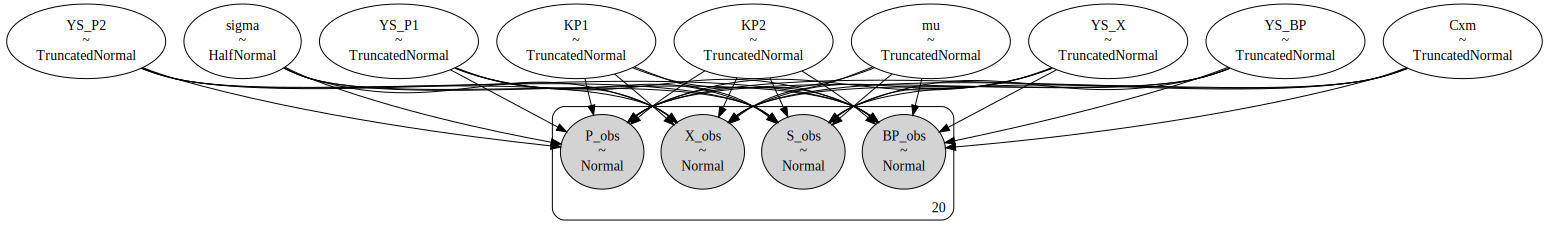

In [17]:
pm.model_to_graphviz(model=succinic_model)

In [18]:
# Create function to plot samples from the posterior distribution using ArviZ extract
def plot_inference(trace, n_samples=10):
    """Plot simulations from posterior samples using ArviZ"""
    plt.figure(figsize=(12, 7))

    # Plot observation points
    plt.scatter(obs_times, CP_obs_noisy, c='r', s=60, marker='o', label='SA (Data)')
    plt.scatter(obs_times, CX_obs_noisy, c='g', s=60, marker='o', label='X (Data)')
    plt.scatter(obs_times, CBP_obs_noisy, c='orange', s=60, marker='o', label='BP (Data)')
    plt.scatter(obs_times, CS_obs_noisy, c='b', s=60, marker='o', label='G (Data)')

    # Plot the true model
    plt.plot(times, CP, 'r-', linewidth=3, alpha=0.7, label='SA (True)')
    plt.plot(times, CX, 'g-', linewidth=3, alpha=0.7, label='X (True)')
    plt.plot(times, CBP, 'orange', linewidth=3, alpha=0.7, label='BP (True)')
    plt.plot(times, CS, 'b-', linewidth=3, alpha=0.7, label='G (True)')

    # Extract samples using ArviZ
    trace_df = az.extract(trace, num_samples=n_samples).to_dataframe()

    # Plot each sample
    for i in range(n_samples):
        # Extract parameter values
        params_sample = trace_df.iloc[i][['Cxm', 'KP1', 'KP2', 'mu', 'YS_P1', 'YS_P2', 'YS_BP', 'YS_X']].values

        # Simulate with these parameters
        solution_sample = odeint(rhs, initial_conditions, times, args=(params_sample,))

        # Plot with low alpha - one line per variable type
        plt.plot(times, solution_sample[:, 2], 'r-', alpha=0.2)  # SA
        plt.plot(times, solution_sample[:, 0], 'g-', alpha=0.2)  # X
        plt.plot(times, solution_sample[:, 3], 'orange', alpha=0.2)  # BP
        plt.plot(times, solution_sample[:, 1], 'b-', alpha=0.2)  # G

    plt.xlabel('Time (h)', fontsize=12)
    plt.ylabel('Concentration (g/L)', fontsize=12)
    plt.title('Model Fit with Posterior Simulations (Slice Sampler)', fontsize=14)
    plt.legend()
    plt.grid(True)


In [19]:
# Get all RVs except for observations
vars_list = list(succinic_model.values_to_rvs.keys())[:-4]  # Exclude the observations

In [20]:
sampler = "DEMetropolisZ"
tune = draws = 5000

with succinic_model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains=4)
trace = trace_DEMZ
az.summary(trace)

Output()

/usr/local/lib/python3.11/dist-packages/pymc/step_methods/metropolis.py:1228: RuntimeWarning: overflow encountered 
in exp
  "accept": np.exp(accept),

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Cxm,4.379,1.029,1.805,5.366,0.437,0.291,6.0,11.0,1.87
KP1,0.008,0.004,0.001,0.015,0.002,0.001,5.0,12.0,2.41
KP2,0.023,0.010,0.010,0.048,0.004,0.003,5.0,11.0,2.00
YS_BP,0.817,0.616,0.101,2.083,0.279,0.152,5.0,11.0,2.56
YS_P1,0.232,0.114,0.100,0.439,0.053,0.024,5.0,23.0,2.32
YS_P2,2.544,0.719,1.829,4.534,0.322,0.341,6.0,11.0,1.79
YS_X,0.869,0.777,0.100,1.946,0.369,0.048,5.0,12.0,2.19
mu,0.940,0.095,0.753,1.086,0.038,0.015,6.0,20.0,1.70
sigma,0.733,0.260,0.469,1.182,0.118,0.044,6.0,28.0,1.69


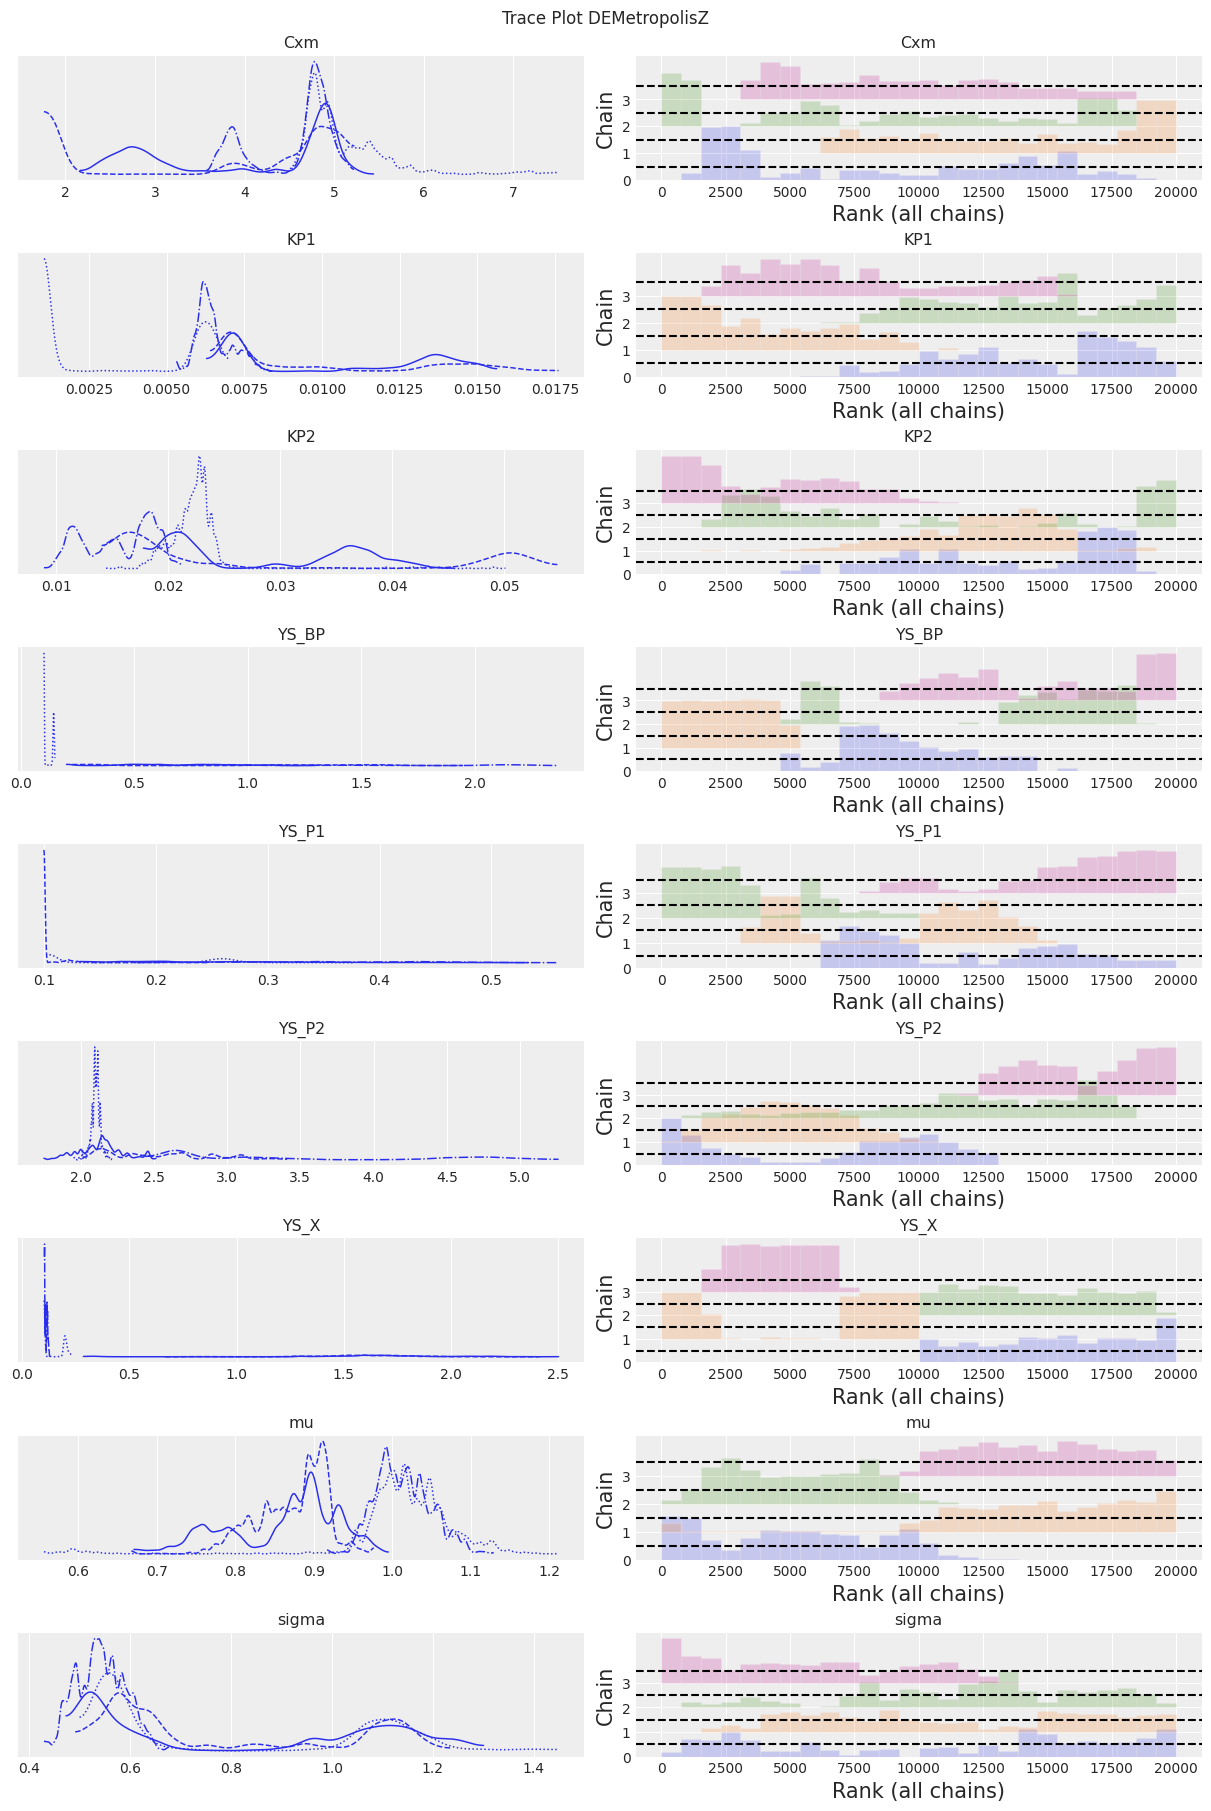

In [22]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}")
plt.show()